In [1]:
# default import, might be useless

# deep learning library
import torch
import torchvision
from   torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

# to import data
import torchvision.transforms as transforms 
import torchvision.datasets.mnist as mnist  

# we use torch.cuda.Event(enable_timing=True) to measure time
# if you don't have cuda, you can use instead :
# from timeit import default_timer as timer
# import time

import collections           # for ordered_dictionnary
import torch.nn.init as init # to initialize model

import copy # for copy.deepcopy( ... )

import numpy as np

# to make and display plots
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure 

# to format time to strings
import datetime                      

import math # for ceil ()

import IPython.display # to display .png

import time
import collections
import os
import sys
import torch
import torch.nn
from torch.autograd import Variable
import torch.nn as nn

from torch.distributions.normal import Normal
from torchvision.utils import *

In [2]:
import torch
import torchvision.datasets
import torchvision.transforms as transforms
from torch.utils.data import dataset
from torch import nn
# from torch.nn.modules import upsampling
# from torch.functional import F
from torch.optim import Adam

In [3]:
# Use the GPU if you have one
if torch.cuda.is_available():
    print("Using the GPU")
    device = torch.device("cuda") 
else:
    print("WARNING: You are about to run on cpu")
    device = torch.device("cpu")


Using the GPU


In [4]:
image_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((.5, .5, .5),
                         (.5, .5, .5))
])


def get_data_loader(dataset_location, batch_size):
    trainvalid = torchvision.datasets.SVHN(
        dataset_location, split='train',
        download=True,
        transform=image_transform
    )

    trainset_size = int(len(trainvalid) * 0.9)
    trainset, validset = dataset.random_split(
        trainvalid,
        [trainset_size, len(trainvalid) - trainset_size]
    )

    trainloader = torch.utils.data.DataLoader(
        trainset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2
    )

    validloader = torch.utils.data.DataLoader(
        validset,
        batch_size=batch_size,
    )

    testloader = torch.utils.data.DataLoader(
        torchvision.datasets.SVHN(
            dataset_location, split='test',
            download=True,
            transform=image_transform
        ),
        batch_size=batch_size,
    )

    return trainloader, validloader, testloader

In [5]:
# functions to show an image

def imshow(img):
    img = 0.5*(img + 1)
    npimg = img.numpy()
    # npimg = (255*npimg).astype(np.uint8) # to be a int in (0,...,255)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


In [6]:
# sets are called train, valid, test
batch_size = 32
trainset, validset, testset = get_data_loader("svhn", batch_size)

Using downloaded and verified file: svhn\train_32x32.mat
Using downloaded and verified file: svhn\test_32x32.mat


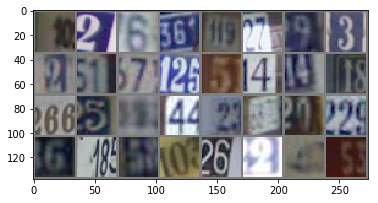

tensor(1)


In [7]:
# get some random training images
dataiter = iter(trainset)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

print( labels[0] )

In [28]:
class UnFlatten(nn.Module):
    def __init__(self, n_channel=16, p_size=8 ):
        super(UnFlatten, self).__init__()
        self.n_channel = n_channel
        self.p_size    = p_size
        
    def forward(self, input):
        return input.view(input.size(0), self.n_channel, self.p_size, self.p_size).contiguous()

    
def make_CGAN_decoder(z_dim=100,ngf=64,nc=3):
    decoder = nn.Sequential(
            # input is Z, going into a convolution
            UnFlatten(z_dim,1),
            nn.ConvTranspose2d(z_dim, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2,     ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.Conv2d( ngf, nc, 5, stride=1, padding=2, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )
    return decoder

def make_standard_decoder_A(z_dim = 100):
    decoder = nn.Sequential(
        nn.Linear(in_features=z_dim, out_features=4*256),
        nn.BatchNorm1d(4*256),
        nn.ELU(),
        nn.Linear(in_features=4*256, out_features=16*512),
        nn.BatchNorm1d(16*512),
        nn.ELU(),
        UnFlatten(512,4),
        nn.Conv2d(512, 256, kernel_size=(3, 3), padding=(2, 2)),
        nn.BatchNorm2d(256),
        nn.ELU(),
        nn.UpsamplingBilinear2d(scale_factor=2),
        nn.Conv2d(256, 64, kernel_size=(3, 3), padding=(2, 2)),
        nn.BatchNorm2d(64),
        nn.ELU(),
        nn.UpsamplingBilinear2d(scale_factor=2),
        nn.Conv2d(64, 32, kernel_size=(3, 3), padding=(2, 2)),
        nn.BatchNorm2d(32),
        nn.ELU(),
        nn.Conv2d(32, 16, kernel_size=(3, 3), padding=(2, 2)),
        nn.BatchNorm2d(16),
        nn.ELU(),
        nn.Conv2d(16, 3, kernel_size=(3, 3), padding=(1, 1)),
    )
    return decoder

def make_standard_decoder_B(z_dim = 100):
    decoder = nn.Sequential(
        nn.Linear(in_features=z_dim, out_features=4*256),
        nn.BatchNorm1d(4*256),
        nn.ReLU(),
        nn.Linear(in_features=4*256, out_features=16*256),
        nn.BatchNorm1d(16*256),
        nn.ReLU(),
        UnFlatten(256,4),
        nn.Conv2d(256, 64, kernel_size=(3, 3), padding=(2, 2)),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.UpsamplingBilinear2d(scale_factor=2),
        nn.Conv2d(64, 32, kernel_size=(3, 3), padding=(2, 2)),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.UpsamplingBilinear2d(scale_factor=2),
        nn.Conv2d(32, 16, kernel_size=(3, 3), padding=(2, 2)),
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.Conv2d(16, 8, kernel_size=(3, 3), padding=(2, 2)),
        nn.BatchNorm2d(8),
        nn.ReLU(),
        nn.Conv2d(8, 4, kernel_size=(3, 3), padding=(1, 1)),
        nn.BatchNorm2d(4),
        nn.ReLU(),
        nn.Conv2d(4, 3, kernel_size=(3, 3), padding=(1, 1))
    )
    return decoder

def make_deconv_decoder_A(z_dim = 100):
    decoder = nn.Sequential(
            nn.Linear(z_dim, 128 * 8 * 8), 
            nn.ReLU(),
            UnFlatten(128,8),
            nn.ConvTranspose2d(128, 128, kernel_size=3, stride=2, padding=1, output_padding=1), 
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 128, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 128, kernel_size=3, stride=2, padding=1, output_padding=1), 
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128,  3, kernel_size=3, stride=1, padding=1)
        )
    return decoder

def make_deconv_decoder_B(z_dim = 100):
    decoder = nn.Sequential(
            nn.Linear(z_dim, 1024 * 8 * 8), 
            nn.ReLU(),
            UnFlatten(1024,8),
            nn.ConvTranspose2d(1024, 512, kernel_size=3, stride=2, padding=1, output_padding=1), 
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 64, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1), 
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32,  3, kernel_size=3, stride=1, padding=1)
        )
    return decoder

def make_deconv_decoder_C(z_dim = 100):
    decoder = nn.Sequential(
            nn.Linear(z_dim, 16 * 8 * 8), 
            nn.ReLU(),
            UnFlatten(),
            nn.ConvTranspose2d(16, 32, kernel_size=3, stride=2, padding=1, output_padding=1), 
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 32, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 32, kernel_size=3, stride=2, padding=1, output_padding=1), 
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32,  3, kernel_size=3, stride=1, padding=1)
        )
    return decoder

def make_dense_decoder_A(z_dim = 100, hidden_size=16*8*8, out_size=128*8*8):
    decoder = nn.Sequential(
            nn.Linear(z_dim, hidden_size), 
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size), 
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size), 
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, out_size), 
            nn.BatchNorm1d(out_size),
            nn.ReLU(),
            UnFlatten(128,8),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1), 
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(32),
            nn.Tanh(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1), 
            nn.BatchNorm2d(16),
            nn.Tanh(),
            nn.ConvTranspose2d(16,  3, kernel_size=3, stride=1, padding=1),
            nn.Tanh()
        )
    return decoder

def make_res_conv_decoder_A():
    decoder = nn.Sequential(
        res_layer( nn.Conv2d(3, 3, kernel_size=(5, 5), padding=(2, 2)) ),
        res_layer( nn.Conv2d(3, 3, kernel_size=(5, 5), padding=(2, 2)) ),
        res_layer( nn.Conv2d(3, 3, kernel_size=(5, 5), padding=(2, 2)) )
    )
    return decoder

class res_layer(nn.Module):
    def __init__(self, layer, n_channel):
        super(res_layer, self).__init__()
        self.layer = layer
        self.relu  = nn.ReLU()
        self.bn    = nn.BatchNorm2d(n_channel)
    
    def forward(self, x):
        return x + self.relu(self.bn(layer.forward(x)))

def make_conv_encoder_A(kernel_s, pad, drop_p):
    encoder = nn.Sequential(
        # layer 1, input size for svhn : 3x32x32
        nn.Conv2d(in_channels=3, out_channels=16, kernel_size=kernel_s,padding=pad),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.Dropout(p= drop_p),

        # layer 2
        nn.Conv2d(16, 32, kernel_size=kernel_s,padding=pad),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.Dropout(p= drop_p),

        # layer 3
        nn.Conv2d(32, 64, kernel_size=kernel_s,padding=pad),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.Dropout(p= drop_p),

        # layer 4
        nn.Conv2d(64, 128, kernel_size=kernel_s,padding=pad),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.Dropout(p= drop_p),

        # layer 5
        nn.Conv2d(128, 256, kernel_size=kernel_s,padding=pad),
        # nn.MaxPool2d(kernel_size=2, stride=2),
    )
    return encoder

class MLP(nn.Module):
    """
    This is just an MLP with 1 hidden layer
    """
    def __init__(self, in_size, h_size, out_size, dropout=0.1):
        super(MLP, self).__init__()
        self.w_1 = nn.Linear(in_size, h_size  )
        self.w_2 = nn.Linear(h_size , out_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

class VAE(nn.Module):
    def __init__(self, drop_p = 0.3, K = 1, kernel_s = 5, z_dim=100 ):
        super(VAE, self).__init__()
        
        self.setIWAE(K)
        self.drop_p   = drop_p
        self.kernel_s = kernel_s
        pad = (kernel_s - 1)//2
        
        # self.encoder = make_conv_encoder_A(kernel_s,pad, drop_p) <-- 5,2,drop_p = 0.1 for save_5
        self.encoder = make_conv_encoder_A(kernel_s,pad, drop_p)
        
        encoder_conv_out_size = 2*2*256
        
        self.encode_to_avg = MLP(encoder_conv_out_size,2048, z_dim, dropout=drop_p)
        self.encode_to_std = nn.Sequential(
            MLP(encoder_conv_out_size,2048, z_dim, dropout=drop_p),
            nn.ReLU()
        )
        
        # self.decoder = make_deconv_decoder_B(z_dim) # <-- save_2 
        # self.decoder = make_dense_decoder_A(z_dim)
        # self.decoder = make_deconv_decoder_C(z_dim)
        # self.decoder = make_standard_decoder_A(z_dim)
        # self.decoder   = make_CGAN_decoder(100,128) # <-- save_3 
        self.decoder   = make_CGAN_decoder(100,192)
        
        # self.decode_fitted_var = nn.Sequential(
        #     MLP(3*32*32,128,3*32*32),
        #     nn.ReLU(),
        #     UnFlatten(3,32)
        # ) # fit variance after generating the picture
        
        # self.decoder = make_standard_decoder(z_dim)
    
    def setIWAE(self, newK ):
        self.K    = newK
        if newK > 1 :
            self.IWAE = True
        else :
            self.IWAE = False
        
    def encode(self, x):
        h = self.encoder(x).view(x.size(0),-1)
        mu, std = self.encode_to_avg(h), self.encode_to_std(h)
        std = std + 1e-03 # added for stability, so that outout > 0
        return mu, std

    def reparameterize(self, m, v):
        if self.IWAE :
            bs = m.size(0)
            K  = self.K
            dz = m.size(-1)
            
            m = m.unsqueeze(1).repeat(1,K,1).contiguous() # (bs,K,dimz)
            m = m.view(bs*K,dz).contiguous()              # (bs*K,dimz)
            
            v = v.unsqueeze(1).repeat(1,K,1).contiguous() # (bs,K,dimz)
            v = v.view(bs*K,dz).contiguous()              # (bs*K,dimz)
            
            eps = torch.randn_like(v)
            z   = m + eps*v 
        else : # only one sample for ELBO
            eps = torch.randn_like(v)
            z   = m + eps*v
        return z

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, std = self.encode(x)
        z       = self.reparameterize(mu, std)
        x_hat   = self.decode(z)
        # v_hat = self.decode_fitted_var(x_hat.view(x.size(0),-1)) + 1e-03 # added for stability, so that outout > 0
        return x_hat, z, mu, std # beware : if self.K > 1, x_hat and x dont have the same shape
    
    def init(self):
        def init_(layer):
            if type(layer) == nn.Linear or type(layer) == nn.Conv2d or type(layer) == nn.ConvTranspose2d:
                init.xavier_uniform_( layer.weight )
                # layer.bias.data.fill_(0.0)
        self.apply(init_)

In [29]:
def number_of_params( net ) :
    nb_param  = 0
    depth     = 0 # count the number of different bias
    param_lst = " "
    for i, (key, value) in enumerate( net.state_dict().items() ) :
        if key.endswith("bias") :
            depth = depth + 1            
        nb_param_tmp = 1        
        for j , x in enumerate(value.size()) :               
            nb_param_tmp = nb_param_tmp * x                
        nb_param = nb_param + nb_param_tmp     
    return nb_param, depth

In [30]:
z_dim = 100
# model = make_conv_encoder_A(11,5,0)
# model = MLP(2*2*256,2048, 100, 0)
model = VAE( drop_p = 0.1, K = 1, kernel_s = 11, z_dim=100 )
# model = make_CGAN_decoder(100,192)
# model = make_dense_decoder_A(z_dim)
# model =  make_deconv_decoder_B(z_dim)
num_p, depth = number_of_params( model )
print( num_p )

37137520


In [9]:
model_VAE = VAE(drop_p = 0.1, K = 1)
model_VAE.init()
_ = model_VAE.to(device)

AttributeError: 'NoneType' object has no attribute 'data'

In [11]:
dataiter = iter(trainset)
images, labels = dataiter.next()
images = images.to(device)
out =  model_VAE(images)
print( out[0].shape )
print( out[0].min() )
print( out[0].max() )

NameError: name 'trainset' is not defined

In [31]:
def kl_loss(z_avg, z_std):
    kl_loss = 0.5 * torch.sum(-1 - 2*z_std.log() + z_avg**2 + z_std**2, dim=-1)
    return kl_loss

sqrt_2p = math.log(2 * math.pi)
def log_px_z(x, x_decoded_mean):
    # loss = 0.5 * ( sqrt_2p + x_decoded_var.log() + (x - x_decoded_mean)**2 /x_decoded_var )
    loss = 0.5 * ( sqrt_2p + (x - x_decoded_mean)**2 )
    loss = torch.sum(loss.view(x.size(0),-1), dim=-1)
    return -loss

def vae_loss(x, x_hat, z_avg, z_std,cst=1):
    logprob = log_px_z(x, x_hat)
    kldiv   = kl_loss(z_avg, z_std)
    kldiv_  = torch.max(kldiv, 3 * torch.ones_like(kldiv)) # prevent kl_div to go to zero
    return - ( logprob - cst*kldiv_), kldiv

def IWAE_loss(x , x_hat, z, z_avg, z_std):
    # x     is (bs,    3, 32, 32)
    # x_hat is (bs, K, 3, 32, 32)
    # z     is (bs, K, 100)
    # z_avg is (bs, 100)
    
    bs = x_hat.size(0)
    K  = x_hat.size(1)
    zd = z.size(-1)
    x     = x.unsqueeze(1)
    z_avg = z_avg.unsqueeze(1)
    z_std = z_std.unsqueeze(1)
        
    prior     = Normal( torch.zeros(1,1,zd, device=device) , torch.ones(1,1,zd, device=device) )
    posterior = Normal( z_avg , z_std )

    log_qz_x = posterior.log_prob(z).sum(-1)  
    log_pz   = prior.log_prob(z).sum(-1)  
    log_px_z = - 0.5 * ( sqrt_2p + (x - x_hat)**2 )
    log_px_z = torch.sum(log_px_z.view(bs,K,-1), dim=-1)
    
    ESM       = log_pz + log_px_z - log_qz_x
    ESM_max,_ = ESM.max(-1)
    ESM_max   = ESM_max.unsqueeze(-1)
    Kt        = torch.tensor(K,dtype=torch.float,device=device)
    LK        = torch.sum(torch.exp(ESM - ESM_max), dim=-1) 
    LK        = LK.log() - Kt.log() + ESM_max
    return -LK
    
            

In [32]:
def train(model,optimizer,loader,epoch,cst):
    model.train()
    train_loss = 0
    train_step = 0
    kl_div     = -1
    for batch_idx, (data,_) in enumerate(loader):
        if batch_idx == 0:
            bs = data.size(0) # batch size 
            
        data = data.to(device)
        optimizer.zero_grad()
        x_hat, z, z_avg, z_std = model(data)
        if model.IWAE :
            bs = data.size(0)
            K  = model.K
            dz = z.size(-1)
            z     = z.view(bs,K,dz).contiguous() # (bs,K,dimz)
            x_hat = x_hat.view(bs,K,3,32,32).contiguous() # (bs,K,...)
            
            loss = IWAE_loss(data , x_hat, z, z_avg, z_std)
            loss = loss.mean()
        else : #  elbo
            loss, kl_div = vae_loss(data, x_hat, z_avg, z_std, cst)
            loss = loss.mean()
            kl_div = kl_div.mean()
        
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            n_batch_seen = batch_idx + 1
            print('Train Epoch: {} ({:.0f}%)\tELBO: {:.6f} \tKL div: {:.6f}'.format(
                epoch, 100* n_batch_seen // len(loader), train_loss / n_batch_seen, kl_div) )

    # Normalize per instance
    avg_loss = train_loss / len(loader)
    print('====> Epoch: {} - Train set - Per instance ELBO: {:.4f}'.format(
        epoch, avg_loss ))
    return avg_loss

def valid(model,optimizer,loader,epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for batch_idx, (data,_) in enumerate(loader):
            if batch_idx == 0:
                bs = data.size(0) # batch size 
                
            data = data.to(device)
            x_hat, z, z_avg, z_std = model(data)
            
            if model.IWAE :
                bs = data.size(0)
                K  = model.K
                dz = z.size(-1)
                z     = z.view(bs,K,dz).contiguous() # (bs,K,dimz)
                x_hat = x_hat.view(bs,K,3,32,32).contiguous() # (bs,K,...)

                loss = IWAE_loss(data , x_hat, z, z_avg, z_std)
                loss = loss.mean()
            else : #  elbo
                loss, kl_div = vae_loss(data, x_hat, z_avg, z_std)
                loss = loss.mean()
                kl_div = kl_div.mean()
            
            test_loss += loss.item()
    # Normalize per instance.
    avg_loss = test_loss / len(loader)                
    print('====> Epoch: {} - Valid set - Per Instance ELBO: {:.4f}'.format(
        epoch, avg_loss))
    return avg_loss

In [33]:
# sets are called train, valid, test
batch_size = 64
# batch_size = 10
trainset, validset, testset = get_data_loader("svhn", batch_size)

Using downloaded and verified file: svhn\train_32x32.mat
Using downloaded and verified file: svhn\test_32x32.mat


In [34]:
print(len(trainset.dataset))
print(len(validset.dataset))
print(len(testset.dataset))

65931
7326
26032


In [35]:
save_dir = "save"

train_losses = []
valid_losses = []
times        = []
best_val_so_far = np.inf

In [36]:
model_VAE = VAE(drop_p = 0.1, K = 1, kernel_s = 11, z_dim=100)
model_VAE.init()

In [255]:
load = True
if load :
    load_dir = "old\save_5\\"
    fn       = "best_params.pt"
    PATH     = load_dir + fn
    model_VAE.load_state_dict(torch.load(PATH))

In [302]:
save = True
if save :
    save_dir = "old\save_1\\"
    fn       = "best_params.pt"
    PATH     = save_dir + fn
    torch.save(model_VAE.state_dict(), PATH)

In [37]:
# optimizer = optim.SGD(model_VAE.parameters() , lr=.5*1e-5, momentum=0, dampening=0, weight_decay=0, nesterov=False)
optimizer = optim.Adam(model_VAE.parameters(), lr=1*1e-3, weight_decay=0, amsgrad=True) # amsgrad=True
# optimizer = optim.Adam(model_VAE.parameters())
cuda = torch.cuda.is_available()
if cuda:
    model_VAE = model_VAE.cuda()

In [ ]:
regul_schedule = [0.001,0.025,0.05,0.075,0.1,0.25,0.5,0.75,0.9,1]
# regul_schedule = [2.5,5,10,10,5,2.5,1,1,1,1]
# regul_schedule = 1.25*np.ones(3)

n_epochs = 10
for epoch in range(1, n_epochs + 1):
    t0 = time.time()
    
    train_loss = train(model_VAE,optimizer,trainset,epoch,regul_schedule[epoch-1])
    valid_loss = valid(model_VAE,optimizer,validset,epoch)
    if valid_loss < best_val_so_far:
        best_val_so_far = valid_loss
        print("Saving model parameters to best_params.pt")
        torch.save(model_VAE.state_dict(), os.path.join(save_dir, 'best_params.pt'))
    
     # LOC RESULTS
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    times.append(time.time() - t0)
    log_str = 'epoch: ' + str(epoch) + '\n' \
            + 'train loss: ' + str(train_loss) + '\n' \
            + 'valid loss: ' + str(valid_loss)  + '\n' \
            + 'best val: '   + str(best_val_so_far) + '\n' \
            + 'time (s) spent in epoch: ' + str(times[-1])
    print(log_str)
    with open (os.path.join(save_dir, 'log.txt'), 'a') as f_:
        f_.write(log_str+ '\n')

# SAVE LEARNING CURVES
lc_path = os.path.join(save_dir, 'learning_curves.npy')
print('\nDONE\n\nSaving learning curves to '+lc_path)
np.save(lc_path, {'train_losses':train_losses,
                  'valid_losses':valid_losses,
                  'times':times})

Train Epoch: 1 (0%)	ELBO: 2871.592285 	KL div: 18.646919
Train Epoch: 1 (9%)	ELBO: 2875.096670 	KL div: 121.068573
Train Epoch: 1 (19%)	ELBO: 2874.292199 	KL div: 124.643448
Train Epoch: 1 (29%)	ELBO: 2874.027333 	KL div: 119.307281
Train Epoch: 1 (38%)	ELBO: 2873.713333 	KL div: 125.045067
Train Epoch: 1 (48%)	ELBO: 2873.321933 	KL div: 124.800674
Train Epoch: 1 (58%)	ELBO: 2873.086780 	KL div: 139.945358
Train Epoch: 1 (67%)	ELBO: 2873.794030 	KL div: 342.867035
Train Epoch: 1 (77%)	ELBO: 2875.423168 	KL div: 232.358032
Train Epoch: 1 (87%)	ELBO: 2875.522128 	KL div: 242.576141
Train Epoch: 1 (97%)	ELBO: 2875.414682 	KL div: 224.657150
====> Epoch: 1 - Train set - Per instance ELBO: 2875.3804
====> Epoch: 1 - Test set - Per Instance ELBO: 3157.5288
epoch: 1
train loss: 2875.3803647001546
valid loss: 3157.528791610054
best val: 2895.578851052989
time (s) spent in epoch: 610.0558934211731
Train Epoch: 2 (0%)	ELBO: 2873.354492 	KL div: 243.348846
Train Epoch: 2 (9%)	ELBO: 2876.554132 	K

In [38]:
dataiter = iter(trainset)
images, labels = dataiter.next()
images = images.to(device)
xh,v,mu,std = model_VAE(images)

In [39]:
print(xh.max())
print(xh.min())

tensor(0.9964, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(-0.9982, device='cuda:0', grad_fn=<MinBackward1>)


# Qualitative evaluation

In [24]:
# print the total number of param of the model
num_p, depth = number_of_params( model_VAE )
print( num_p )

18364592


#### Display 32 samples taken from the model where the latent where sampled from the true prior.

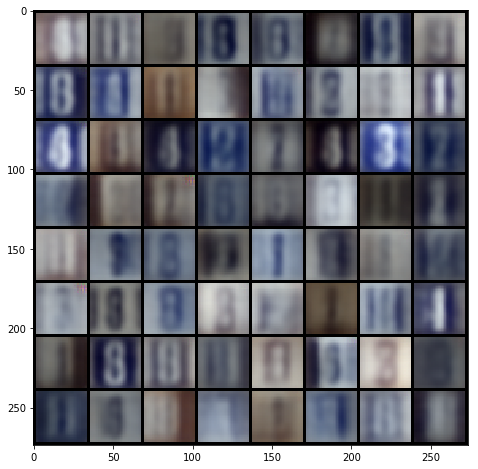

In [39]:
plt.figure(figsize=(8,8))
model_VAE.eval()
generator = model_VAE.decoder
with torch.no_grad() :
    z_dim = 100
    bs    = 64
    mu    = torch.zeros(bs,z_dim)
    std   = torch.ones(bs,z_dim)
    z     = mu + 1.0 * std * torch.randn_like(std)
    z     = z.to(device)
    gen   = generator(z)
    gen_  = gen.cpu()
    # gen_  = gen_ - gen_.min()
    # gen_  = gen_ / gen_.max()
    # print(gen_.shape)
    # imshow(torchvision.utils.make_grid(gen_))
    grid_img = torchvision.utils.make_grid(gen_.cpu(), nrow=8, normalize=True)
    plt.imshow(grid_img.permute(1, 2, 0))

#### Extract from the training set an example of each digit

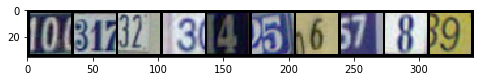

In [283]:
plt.figure(figsize=(8,8))

find_new_examples = False
if find_new_examples :
    found     = torch.zeros(10)
    found_    = 0
    examples_ = torch.empty(10,3,32,32,dtype=torch.float,device='cpu')
    for idx, (data,label) in enumerate(trainset):
        for j in range(label.size(0)):
            l = label[j].item()
            if found[l] == 0:
                found[l] = 1
                found_  += 1
                examples_[l] = data[j,:,:,:]
            else :
                pass
        if found_ == 10 :
            break    
                
find_some_examples = False
if find_some_examples :
    find_again = [9]
    for i in find_again :
        found[i] = 0
        found_  -= 1
    for idx, (data,label) in enumerate(trainset):
        for j in range(label.size(0)):
            l = label[j].item()
            if found[l] == 0:
                found[l] = 1
                found_  += 1
                examples_[l] = data[j,:,:,:]
            else :
                pass
        if found_ == 10 :
            break    

grid_img = torchvision.utils.make_grid(examples_.cpu(), nrow=10, normalize=True)
_ = plt.imshow(grid_img.permute(1, 2, 0))

#### Display the output of the VAE on these chosen example     
This helps visualise the reconstruction error of the VAE. A VAE can do very well on this task, but in order to be able to sample from the VAE, the model should also have a small KL-div between prior and posterior.

torch.Size([9, 10, 3, 32, 32])


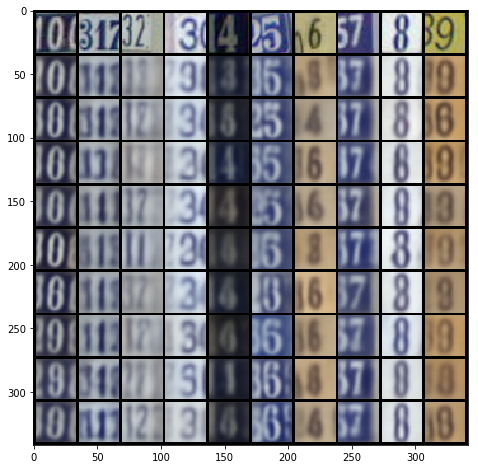

In [284]:
plt.figure(figsize=(8,8))
n_samples = 9
with torch.no_grad():
    model_VAE.setIWAE(n_samples)
    gens_,z_forgens,_,_ = model_VAE(examples_.to(device))
    gens_ = torch.transpose(gens_.view(-1,n_samples,3,32,32),0,1).contiguous()
    print(gens_.shape)
    gens_ = gens_.view(-1,3,32,32)
    # imshow(torchvision.utils.make_grid(gens_.cpu()))
    grid_img = torchvision.utils.make_grid(torch.cat( (examples_.cpu(), gens_.cpu()) , dim=0), nrow=10, normalize=True)
    plt.imshow(grid_img.permute(1, 2, 0))
    model_VAE.setIWAE(1)

In [ ]:
arr = [(1,2),(1,5),(4,7),(4,8),(5,1),(5,7),(6,7),(7,1),(7,6),(6,10),(7,10),(8,1),(8,8)

#### Sample from the prior, and feed it to the decoder with a small perturbation in each of the 100 dimensions.  See the results.     
Few dimensions seem to contribute to the generation process.  


In [192]:
def index_from_pos(arr):
    t   = len(arr)
    ind = torch.zeros(t,dtype=torch.long)
    for k,(i,j) in enumerate(arr) :
        ind[k] = (i-1)*10+(j-1)
    return ind

arr = [(1,2),(1,5),(4,7),(4,8),(5,1),(5,7),(6,7),(7,1),(7,6),(7,10),(8,10),(9,1),(9,8),(10,7),(10,10)]
print( len(arr) )
picked_dim = index_from_pos(arr)

15


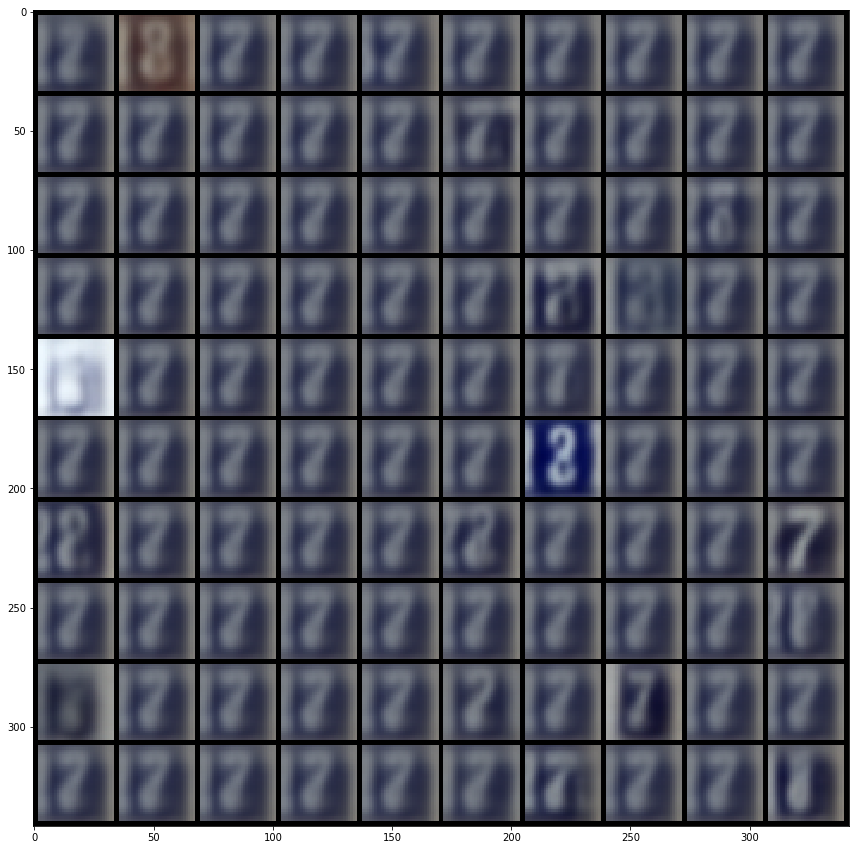

In [213]:
plt.figure(figsize=(15,15))
with torch.no_grad():
    eps     = -2
    eps_mat = torch.eye(100) * eps
    eb      = torch.randn(100).unsqueeze(0)
    # eb      = z[0].cpu().unsqueeze(0)
    e       = eb.repeat(100,1) + eps_mat
    base    = model_VAE.decode(eb.to(device))
    out     = model_VAE.decode( e.to(device))
    out_diff= out - base.repeat(100,1,1,1)
    # grid_img= torchvision.utils.make_grid(out.cpu(), nrow=10, normalize=True)
    # plt.imshow(grid_img.permute(1, 2, 0))
    
    # out_ = F.interpolate(out, 128, mode='bilinear', align_corners=False)
    grid_img= torchvision.utils.make_grid(out.cpu(), nrow=10, normalize=True)
    # grid_img= torchvision.utils.make_grid( torch.index_select(out.cpu(),0,picked_dim) , nrow=5, normalize=True)
    # grid_img= torchvision.utils.make_grid(out_diff.cpu(), nrow=10, normalize=True)
    
    plt.imshow(grid_img.permute(1, 2, 0))

In [187]:
arr = [(1,2),(1,5),(4,7),(4,8),(5,1),(5,7),(6,7),(7,1),(7,6),(7,10),(8,10),(9,1),(9,8),(10,7),(10,10)]

print(ind)

tensor([ 1,  4, 36, 37, 40, 46, 56, 60, 65, 69, 79, 80, 87, 96, 99],
       dtype=torch.int32)


In [185]:
z = torch.randn(4,2,2)
ind = torch.tensor([1,2])
print(z)
y = torch.index_select(z,0,ind)
print(y)

tensor([[[-0.5356,  0.6406],
         [-0.8159, -0.5436]],

        [[-0.1957, -0.3687],
         [ 0.1431, -1.6665]],

        [[-0.1220, -0.3644],
         [-1.1418,  0.0112]],

        [[-1.7229,  0.2379],
         [ 0.8818, -0.0787]]])
tensor([[[-0.1957, -0.3687],
         [ 0.1431, -1.6665]],

        [[-0.1220, -0.3644],
         [-1.1418,  0.0112]]])


#### Compare interpolation in pixel space vs interpolation in space of latent variables.     
In theory, one makes sense and the other is only a lazy way to interpolate. We expect the two to yield different result. In practice however, we only see a very small differences.

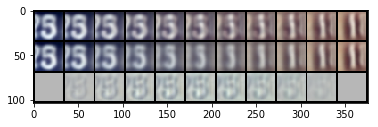

In [139]:
def lazy_interpolation(model,z):
    alpha = torch.linspace(0, 1, steps=11)
    alpha = torch.transpose(alpha.repeat(1,3,32,32,1),0,-1).squeeze(-1)
    alpha = alpha.to(device)
    g = model.decoder(z)
    g = g[0].unsqueeze(0).repeat(11,1,1,1)*(1-alpha) + g[1].unsqueeze(0).repeat(11,1,1,1)*alpha
    return g
    
def latent_interpolation(model,z):
    alpha = torch.linspace(0, 1, steps=11)
    alpha = torch.transpose(alpha.repeat(100,1),0,-1)
    alpha = alpha.to(device)
    z = z[0].unsqueeze(0).repeat(11,1)*(1-alpha) + z[1].unsqueeze(0).repeat(11,1)*alpha
    g = model.decoder(z)
    return g

_ = model_VAE.to(device)
model_VAE.eval()
with torch.no_grad() :
    z_dim = 100
    bs    = 2
    mu    = torch.zeros(bs,z_dim)
    std   = torch.ones(bs,z_dim)
    z     = model_VAE.reparameterize(mu,std).to(device)
    # z     = torch.cat((z_forgens[2].unsqueeze(0),z_forgens[5].unsqueeze(0)),dim=0).to(device)
    lz_interpol = lazy_interpolation(model_VAE,z).cpu()
    lt_interpol = latent_interpolation(model_VAE,z).cpu()
    
    disp     = torch.cat((lz_interpol,lt_interpol,lt_interpol-lz_interpol),dim=0)
    grid_img = torchvision.utils.make_grid(disp.cpu(), nrow=11, normalize=True)
    _ = plt.imshow(grid_img.permute(1, 2, 0))
    
    # imshow(torchvision.utils.make_grid(lz_interpol))
    # imshow(torchvision.utils.make_grid(lt_interpol))
    # diff between the 2 interpol
    # imshow(torchvision.utils.make_grid(lt_interpol-lz_interpol))

# Quantitative evaluation

#### Sample 1000 images from the true prior for each model and put the results in a directory

In [227]:
def save_sample_to_dir(i,sample,dir_):
    # assuming :
    #            sample is 3x32x32
    #            dir_ exists
    # save sample as "i.jpg"
    save_image(sample.cpu(), dir_ + "\{num}.jpg".format(num=i) , normalize=True )   

def generate_samples_and_save_to_dir(model,bn,bs,dir_):
    # assuming the prior is std normal in 100 dim
    # generate bs samples from model and save them to dir
    # numbered from bn to bn + bs
    # where bn : batch number
    #       bs : batch size
    e   = torch.randn(bs,100,device=device)
    gen = model(e)
    for i in range(bs):
        save_sample_to_dir(bn*bs+i,gen[i],dir_)

In [228]:
#### TODO
samples_dir = "sample_directory\VAE\samples"
n_samples  = 1000
batch_size = 100
n_batches  = 10
for i in range(n_batches) :
    generate_samples_and_save_to_dir(model_VAE.decoder,i,batch_size,samples_dir)

In [231]:
image_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((.5, .5, .5),
                         (.5, .5, .5))
])

def get_sample_loader(path, batch_size):
    """
    Loads data from `[path]/samples`
    - Ensure that path contains only one directory
      (This is due ot how the ImageFolder dataset loader
       works)
    - Ensure that ALL of your images are 32 x 32.
      The transform in this function will rescale it to
      32 x 32 if this is not the case.
    Returns an iterator over the tensors of the images
    of dimension (batch_size, 3, 32, 32)
    """
    data = torchvision.datasets.ImageFolder(
        path,
        transform=transforms.Compose([
            transforms.Resize((32, 32), interpolation=2),
            image_transform
        ])
    )
    data_loader = torch.utils.data.DataLoader(
        data,
        batch_size=batch_size,
        num_workers=2,
    )
    return data_loader

In [239]:
# load samples and make sure they are in the correct range of value (i.e. [-1,1])
sample_loader = get_sample_loader("sample_directory\VAE", 32)
sample_iter = iter(sample_loader)
images , _ = sample_iter.next()
# print(images)
print(images.min())
print(images.max())
print(torch.mean(images))

#### Run and report FID score

In [ ]:
#### TODO